# This notebook is readonly and contains legacy investigations. For the most up-to-date version of the classifier please consult the code in the `alphamoon` module.

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
RAW_DATA_DIR = Path('/content/drive/My Drive/tripleloss_data').resolve()
print(RAW_DATA_DIR.is_dir())
OUTPUT_DIR = Path('/content/drive/My Drive').resolve()

True


In [ ]:
import pickle

import numpy as np
import torch.cuda
import torch.nn
import torch.optim
from scipy.ndimage import affine_transform
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path='state_dict_model.pt',
          from_epoch=0, valid_loss_min=np.Inf):
    """returns trained model"""

    for epoch in range(1, n_epochs + 1):
        print(f'Epoch {epoch}')
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(loaders[Phase.TRAIN])):
            # move to GPU
            if use_cuda:
                data = tuple(d.cuda() for d in data)

            optimizer.zero_grad()
            output = model(*data)
            loss = criterion(*output)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(tqdm(loaders[Phase.VALIDATION])):
            # move to GPU
            if use_cuda:
                data = tuple(d.cuda() for d in data)
            output = model.forward(*data)
            loss = criterion(*output)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch + from_epoch,
            train_loss,
            valid_loss
        ))

        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            try:
                save_model(model, epoch=epoch)
            except Exception as e:
                print(f'Could not save the model due to {str(e)}')
            valid_loss_min = valid_loss

    # return trained model
    return model


def save_model(model, directory=OUTPUT_DIR, epoch=-1):
    embedding_model_path = directory / 'embedding_model.pt'
    state_dict_model_path = directory / 'state_dict_model.pt'
    if epoch > 0:
        torch.save(model.embedding_net.state_dict(), directory / f'embedding_model_{epoch}.pt')
        torch.save(model.state_dict(), directory / f'state_dict_model_{epoch}.pt')

    torch.save(model.embedding_net.state_dict(), embedding_model_path)
    torch.save(model.state_dict(), state_dict_model_path)
    print(f'Model saved to {state_dict_model_path}, embedding model saved to {embedding_model_path}')


In [ ]:
import torch.nn as nn


class EmbeddingNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1.float())
        output2 = self.embedding_net(x2.float())
        output3 = self.embedding_net(x3.float())
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [ ]:
import random

In [ ]:
import numpy as np


In [ ]:
import numpy as np
from torch.utils.data import Dataset
import random
from enum import Enum
import torch
import torch.utils.data


class Phase(Enum):
    TRAIN = 'train'
    VALIDATION = 'valid'
    TEST = 'test'


class TripletDataset(Dataset):
    """
    Training: for each anchor, a positive and a negative samples are chosen at random
    Testing: fixed triplets ?
    """

    def __init__(self, X, y):
        self.X = X
        self.anchors = []
        self.positives = []
        self.negatives = []

        count_arr = np.bincount(y[:, 0])
        all_classes =  {i: np.where(y == i)[0] for i in range(len(count_arr))}

        for i, count in enumerate(count_arr):
          if count == 0:
            continue
          anchor = list(all_classes[i])
          random.shuffle(anchor)
          self.anchors.extend(anchor)

          positive = list(all_classes[i])
          random.shuffle(positive)
          self.positives.extend(positive)

          population = [x for x, x_count in enumerate(count_arr) if x != i and x_count > 0]
          negative_classes = random.choices(population, k=count)
          for j, neg_count in enumerate(np.bincount(negative_classes)):
            self.negatives.extend(random.choices(all_classes[j], k=neg_count))

        triplets = list(zip(self.anchors, self.positives, self.negatives))
        random.shuffle(triplets)
        self.anchors, self.positives, self.negatives = zip(*triplets)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        return (self.X[self.anchors[index]], self.X[self.positives[index]], self.X[self.negatives[index]]), []

    def __len__(self):
        return len(self.anchors)

def get_data_loaders(X_train, y_train, X_test, y_test, batch_size: int = 10, shuffle: bool = True,
                     num_workers: int = 0, pin_memory: bool = True, train_fraction=0.8):
    data_loaders = dict()
    params = dict(batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)
    data_loaders[Phase.TEST] = torch.utils.data.DataLoader(TripletDataset(X_test, y_test), **params)
    train_dataset = TripletDataset(X_train, y_train)
    total = X_train.shape[0]
    train_size = int(total * train_fraction)
    validation_size = total - train_size
    train_set, validation_set = torch.utils.data.random_split(train_dataset, [train_size, validation_size])
    data_loaders[Phase.TRAIN] = torch.utils.data.DataLoader(train_set, **params)
    data_loaders[Phase.VALIDATION] = torch.utils.data.DataLoader(validation_set, **params)
    return data_loaders

In [ ]:
def get_transformation_matrix(img_w_h):
    import random

    if random.random() > 0.5:
      theta = np.deg2rad(random.randint(-10, 10))
      ry = rx = img_w_h / 2

      r00 = np.cos(theta)
      r01 = -np.sin(theta)
      r10 = np.sin(theta)
      r11 = np.cos(theta)
      r02 = rx - r00 * rx - r01 * ry
      r12 = ry - r10 * rx - r11 * ry

      rotation = np.array([[r00, r01, r02], [r10, r11, r12], [0, 0, 1]])
    else:
      rotation = np.identity(3)

    Sx = Sy = 1.0
    Tx = Ty = 0
    if random.random() > 0.5:
      Sx = random.uniform(0.88, 1.12)
    if random.random() > 0.5:
      Sy = random.uniform(0.88, 1.12)
    if random.random() > 0.5:
      Tx = random.randint(-7, 7)
    if random.random() > 0.5:
      Ty = random.randint(-7, 7)

    affine2 = np.array([[Sy, 0, Tx], [0, Sx, Ty], [0, 0, 1]])
    trans = np.matmul(rotation, affine2)
    return trans

In [ ]:
input_data_path = RAW_DATA_DIR / 'train.pkl'
with input_data_path.open('rb') as file_handle:
    X, y = pickle.load(file_handle)


In [ ]:
"""one_shot_example = np.where(y[:, 0] == 30)[0][0]

img_w_h = int(np.sqrt(X.shape[1]))
image = np.reshape(X[one_shot_example], (img_w_h, img_w_h))

def transform(image, img_w_h):
  return np.ravel(affine_transform(image, get_transformation_matrix(img_w_h)))

# add 3 images
X_augmented = np.vstack((X, transform(image, img_w_h)))
X_augmented = np.vstack((X_augmented, transform(image, img_w_h)))
X_augmented = np.vstack((X_augmented, transform(image, img_w_h)))

# add 3 images, check how that can be accomplished in one line
y_augmented = np.vstack((y, [30, 30, 30]))"""


In [ ]:
# fixing the data
one_shot_example = np.where(y[:, 0] == 30)[0][0]

X_augmented = X.copy()
y_augmented = y.copy()
y_augmented[one_shot_example] = 14

In [ ]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=0)
for train_index, test_index in ss.split(X_augmented, y_augmented):
    X_train, X_test = X_augmented[train_index], X_augmented[test_index]
    y_train, y_test = y_augmented[train_index], y_augmented[test_index]


In [ ]:
X_train_augmented = np.vstack((X_train, X_train))
y_train_augmented = np.vstack((y_train, y_train))

img_w_h = int(np.sqrt(X.shape[1]))
X_train_augmented = np.reshape(X_train_augmented, (X_train_augmented.shape[0], img_w_h, img_w_h))
for i in range(X_train_augmented.shape[0]):
  X_train_augmented[i,:,:] = affine_transform(X_train_augmented[i,:,:], get_transformation_matrix(img_w_h))
X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)


In [ ]:
embedding_length = 64
embedding_model = EmbeddingNet(X_train_augmented.shape[1], embedding_length, embedding_length)
model = TripletNet(embedding_model)


In [ ]:
# set up everything
n_epochs = 10
margin = 10
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()
loss_fn = torch.nn.TripletMarginWithDistanceLoss(
    distance_function=torch.nn.PairwiseDistance(), margin=margin)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
loaders = get_data_loaders(X_train_augmented, y_train_augmented, X_test, y_test)

In [ ]:
train(n_epochs, loaders, model, optimizer, loss_fn, use_cuda)

  1%|          | 38/3231 [00:00<00:08, 379.44it/s]

Epoch 1


  1%|▏         | 43/3231 [00:00<00:07, 426.46it/s]

Epoch: 1 	Training Loss: 4.278282 	Validation Loss: 3.379864
Validation loss decreased (inf --> 3.379864).  Saving model ...
Model saved to /content/drive/My Drive/state_dict_model.pt, embedding model saved to /content/drive/My Drive/embedding_model.pt
Epoch 2


  1%|          | 40/3231 [00:00<00:08, 397.86it/s]

Epoch: 2 	Training Loss: 2.379395 	Validation Loss: 2.719625
Validation loss decreased (3.379864 --> 2.719625).  Saving model ...
Model saved to /content/drive/My Drive/state_dict_model.pt, embedding model saved to /content/drive/My Drive/embedding_model.pt
Epoch 3


  0%|          | 0/3231 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.596403 	Validation Loss: 2.670454
Validation loss decreased (2.719625 --> 2.670454).  Saving model ...
Model saved to /content/drive/My Drive/state_dict_model.pt, embedding model saved to /content/drive/My Drive/embedding_model.pt
Epoch 4


  1%|▏         | 41/3231 [00:00<00:07, 404.51it/s]

Epoch: 4 	Training Loss: 1.171921 	Validation Loss: 2.646956
Validation loss decreased (2.670454 --> 2.646956).  Saving model ...
Model saved to /content/drive/My Drive/state_dict_model.pt, embedding model saved to /content/drive/My Drive/embedding_model.pt
Epoch 5


  1%|▏         | 41/3231 [00:00<00:07, 403.39it/s]

Epoch: 5 	Training Loss: 0.837726 	Validation Loss: 2.741175
Epoch 6


  1%|          | 32/3231 [00:00<00:10, 314.30it/s]

Epoch: 6 	Training Loss: 0.637054 	Validation Loss: 2.773639
Epoch 7


  1%|▏         | 42/3231 [00:00<00:07, 418.45it/s]

Epoch: 7 	Training Loss: 0.476225 	Validation Loss: 2.955754
Epoch 8


  1%|▏         | 42/3231 [00:00<00:07, 415.64it/s]

Epoch: 8 	Training Loss: 0.393165 	Validation Loss: 3.015572
Epoch 9


  1%|          | 35/3231 [00:00<00:09, 342.56it/s]

Epoch: 9 	Training Loss: 0.351242 	Validation Loss: 3.194891
Epoch 10


100%|██████████| 808/808 [00:00<00:00, 955.83it/s]

Epoch: 10 	Training Loss: 0.275561 	Validation Loss: 3.292072


TripletNet(
  (embedding_net): EmbeddingNet(
    (fc1): Linear(in_features=3136, out_features=64, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=64, out_features=64, bias=True)
  )
)

# Idea nr 1

For each image in `X_test` get its embedding and train a model? 

In [ ]:
# load the model that got the best validation accuracy (uncomment the line below)
embedding_model.load_state_dict(torch.load(OUTPUT_DIR / 'embedding_model.pt'))

<All keys matched successfully>

In [ ]:
margin

10

In [ ]:
import shutil
# shutil.copy2(OUTPUT_DIR / 'embedding_model.pt', OUTPUT_DIR / f'embedding_model_64_30is14_margin{margin}_augmented2x.pt')

PosixPath('/content/drive/My Drive/embedding_model_64_30is14_margin10_augmented2x.pt')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

X_train_data = torch.from_numpy(X_train_augmented)
X_test_data = torch.from_numpy(X_test)
if use_cuda:
  X_train_data = X_train_data.cuda()
  X_test_data = X_test_data.cuda()

X_train_embedded = embedding_model.forward(X_train_data.float())
X_test_embedded = embedding_model.forward(X_test_data.float())

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier = classifier.fit(X_train_embedded.detach().cpu().numpy(), y_train_augmented.ravel())

In [ ]:
y_pred = classifier.predict(X_test_embedded.detach().cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

print('F1 =', f1_score(y_test.ravel(), y_pred, average='weighted'))
print('Precision =', precision_score(y_test.ravel(), y_pred, average='weighted'))
print('Recall =', recall_score(y_test.ravel(), y_pred, average='weighted'))

F1 = 0.7224937781155444
Precision = 0.7207659582763245
Recall = 0.7261940673705379


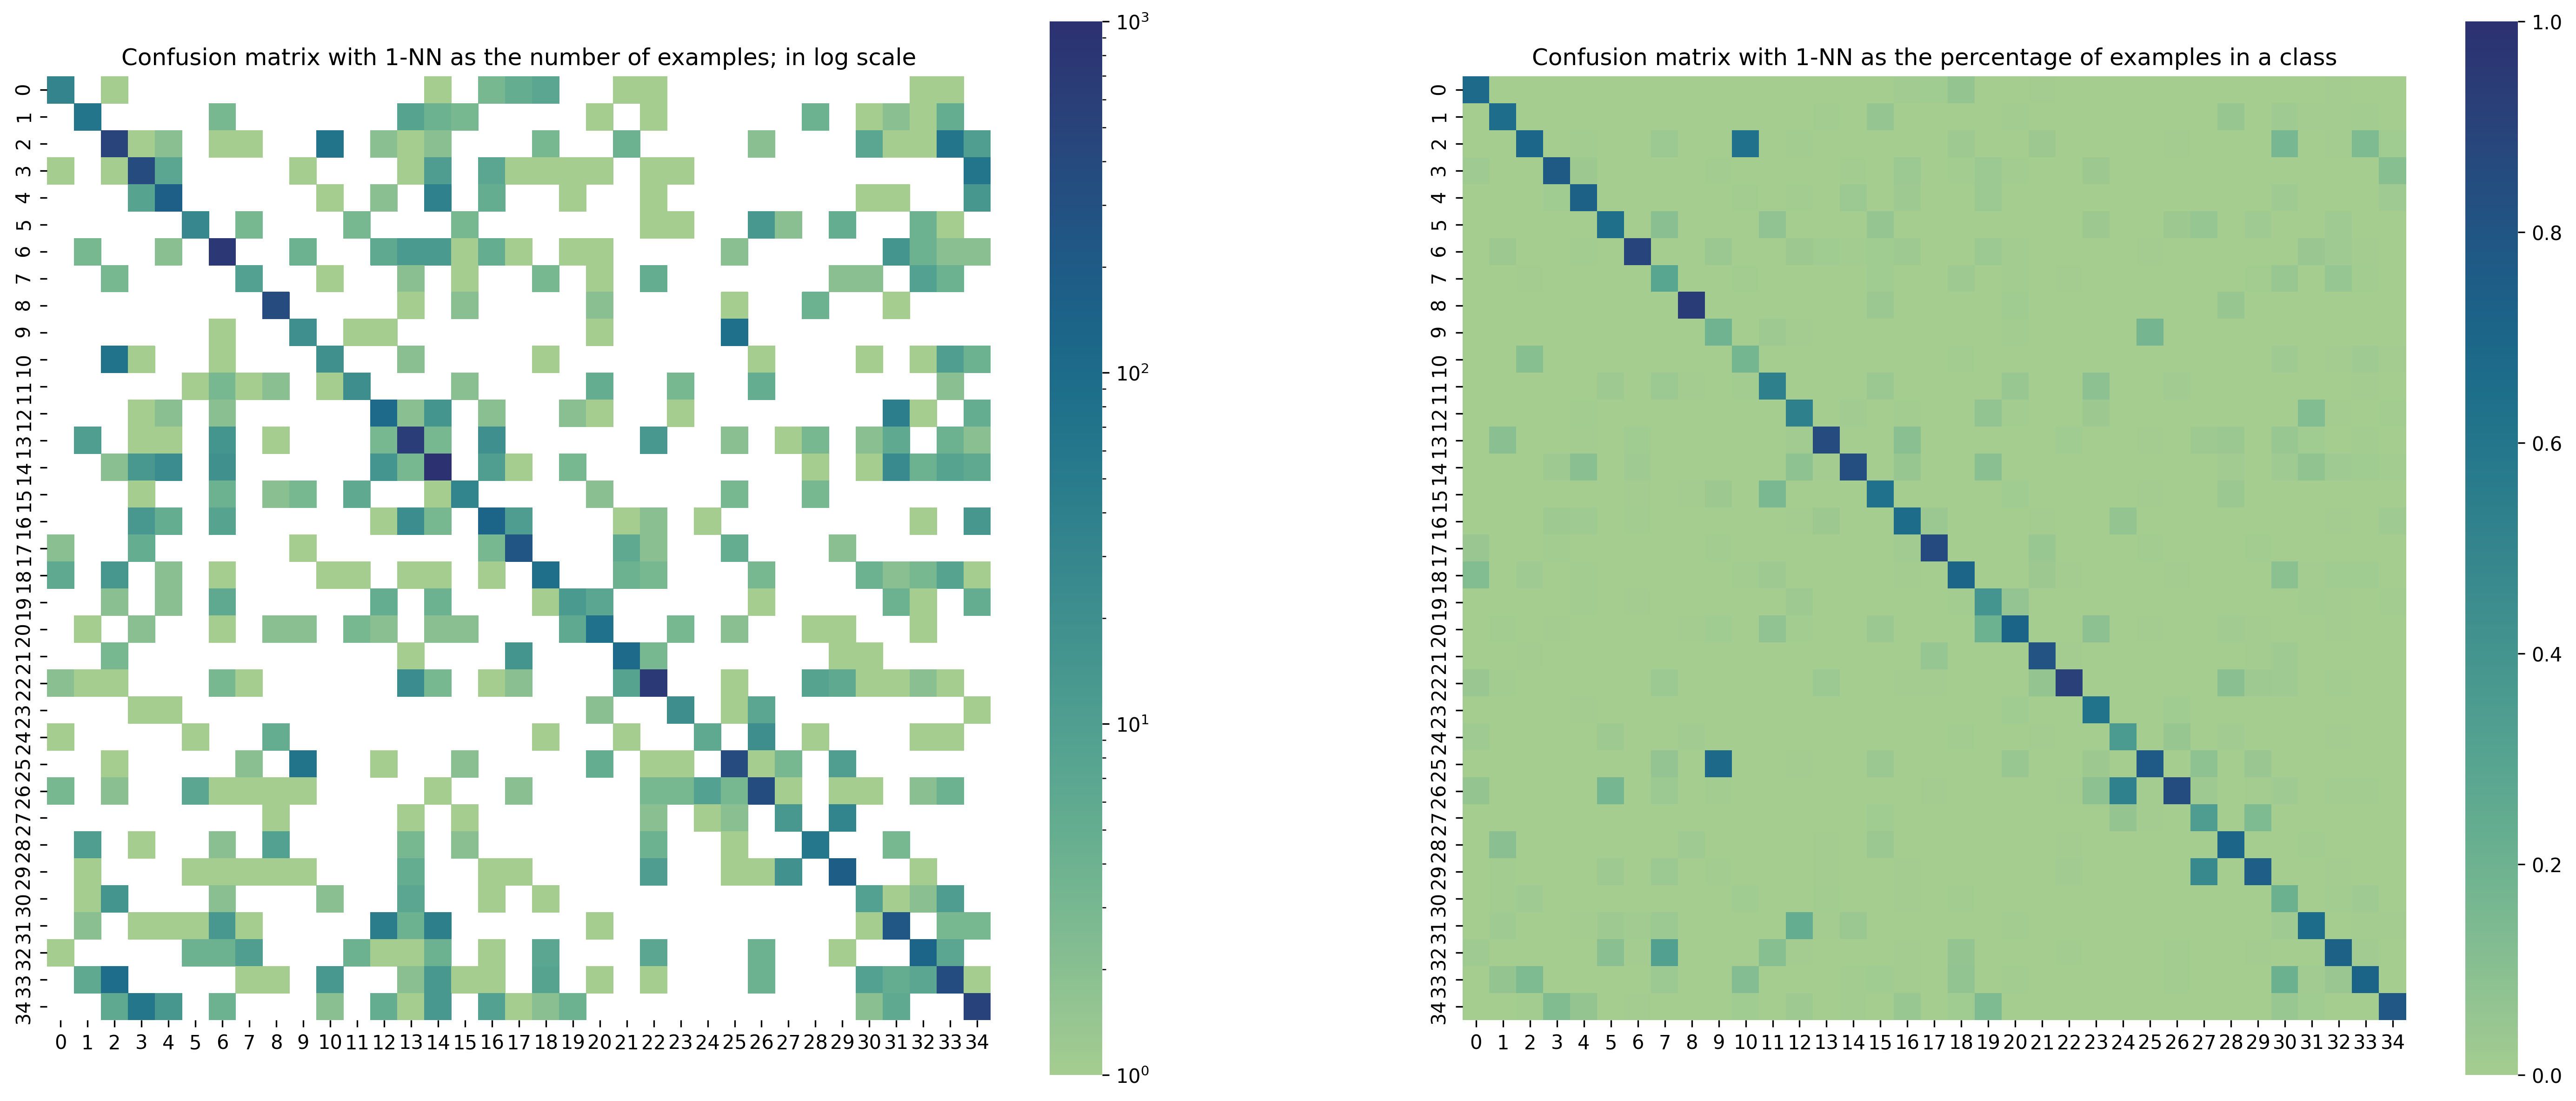

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, (ax1, ax2) = plt.subplots(figsize = (24, 10), nrows=1, ncols=2, dpi=300)

df_cm = pd.DataFrame(confusion_matrix(y_test.ravel(), y_pred), index = [i for i in range(35)], columns = [i for i in range(35)])
df_cm2 = df_cm.loc[:,:].div(df_cm.sum(axis=0))
sns.heatmap(df_cm2, annot=False, ax=ax2, square=True, cmap='crest', vmin=0, vmax=1)
sns.heatmap(df_cm, annot=False, ax=ax1, square=True, cmap='crest', norm=LogNorm(vmin=1, vmax=1000))
ax2.set_title('Confusion matrix with 1-NN as the percentage of examples in a class')
ax1.set_title('Confusion matrix with 1-NN as the number of examples; in log scale')
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', bbox_inches='tight')
plt.show()

1. Experiment 1
    
    * margin 1
    * 64 embedding
    * no additional images (apart from N)
    ```
    Epoch: 2 Training Loss: 0.169091 	Validation Loss: 0.212398
    F1 = 0.7577291682193597
    precision = 0.755081359121997
    recall = 0.7634224813995576
    ```
    Saved as `embedding_model_64.pt`

2. Experiment 2

    * margin 1
    * 128 embedding
    * no additional images
    ```
    Epoch: 1 	Training Loss: 0.331993 	Validation Loss: 0.261527
    F1 = 0.7564225722263996
    Precision = 0.7541940300839498
    Recall = 0.7624170520812387
    ```

It is overfitting extremely fast. I guess I need more images.

Class 14 and class 30 are the same. 

3. Experiment 3
  * margin 1
  * 64 embedding
  * no additional images
  ```
  F1 = 0.7407518483975892
  Precision = 0.7395624407983923
  Recall = 0.7441930618401207
  Epoch: 3 	Training Loss: 0.120639 	Validation Loss: 0.221972
  ```
  Saved as `embedding_model_64_30is14.pt`

4. Experiment 4

  * margin 1
  * 64 embedding
  * 2x images, all augmented

  ```
  F1 = 0.6626109496076849
  Precision = 0.6606860625503794
  Recall = 0.6671694318753142
  Epoch: 3 	Training Loss: 0.234653 	Validation Loss: 0.319424
  ```
  Saved as `embedding_model_64_30is14_augmented2x.pt`

5. Experiment 5

  * margin 10
  * 64 embedding
  * no additional images
  ```
  F1 = 0.77155466192222
  Precision = 0.7697094449176086
  Recall = 0.775062845651081
  Epoch: 3 	Training Loss: 0.940140 	Validation Loss: 1.445811
  ```

  Saved as `embedding_model_64_30is14_margin10.pt`

6. Experiment 6

  * margin 20
  * 64 embedding
  * no additional images

  ```
  Epoch: 6 	Training Loss: 0.675475 	Validation Loss: 3.144919
  F1 = 0.7435698659013236
  Precision = 0.7420534109778945
  Recall = 0.746606334841629
  ```
  Saved as `embedding_model_64_30is14_margin20.pt`

7. 

  * margin 10
  * 64 embedding
  * 2x images
  ```
  F1 = 0.7224937781155444
  Precision = 0.7207659582763245
  Recall = 0.7261940673705379
  Epoch: 4 	Training Loss: 1.171921 	Validation Loss: 2.646956
  ```
  Saved as: `/embedding_model_64_30is14_margin10_augmented2x.pt`  

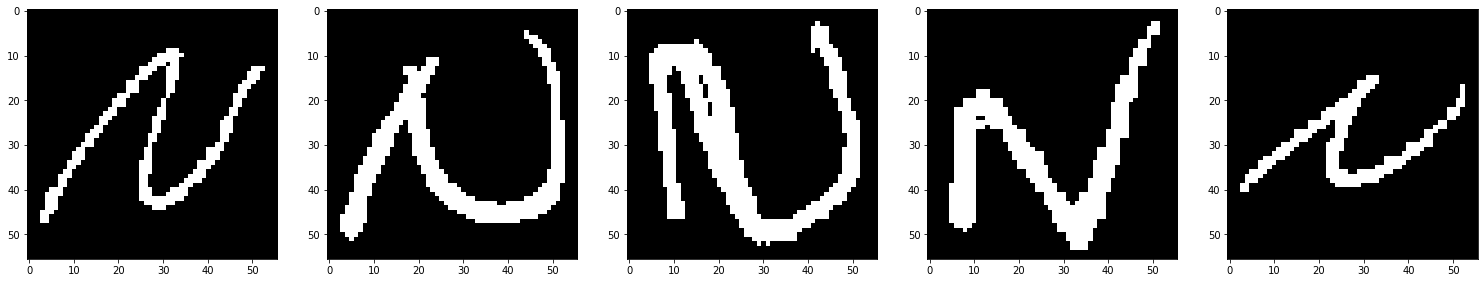

In [ ]:
class14 = np.where(y_train[:,0] == 14)[0]

fig, ax = plt.subplots(figsize=(26, 5), nrows=1, ncols=5)

for i in range(5):
  ax[i].imshow(np.reshape(X_train[class14[i], :], (56, 56)), cmap='gray')

plt.show()

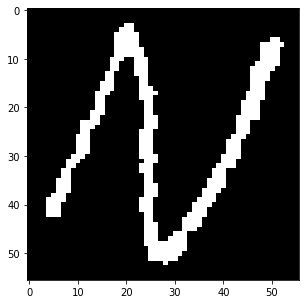

In [ ]:
class30 = np.where(y_train[:,0] == 30)[0]

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.reshape(X_train[class30[0], :], (56, 56)), cmap='gray')

plt.show()

In [ ]:
count_arr = np.bincount(y[:, 0])

In [ ]:
count_arr

array([ 164,  301, 2014, 1429,  735,  191, 2527,  127, 1175,  324,  343,
        141,  548, 2157, 3291,  179,  664,  841,  425,  152,  332,  394,
       2332,  102,  118, 1442, 1235,  168,  287,  701,    1,  158, 1073,
        561, 1578, 1924])

In [ ]:
len(count_arr)

36

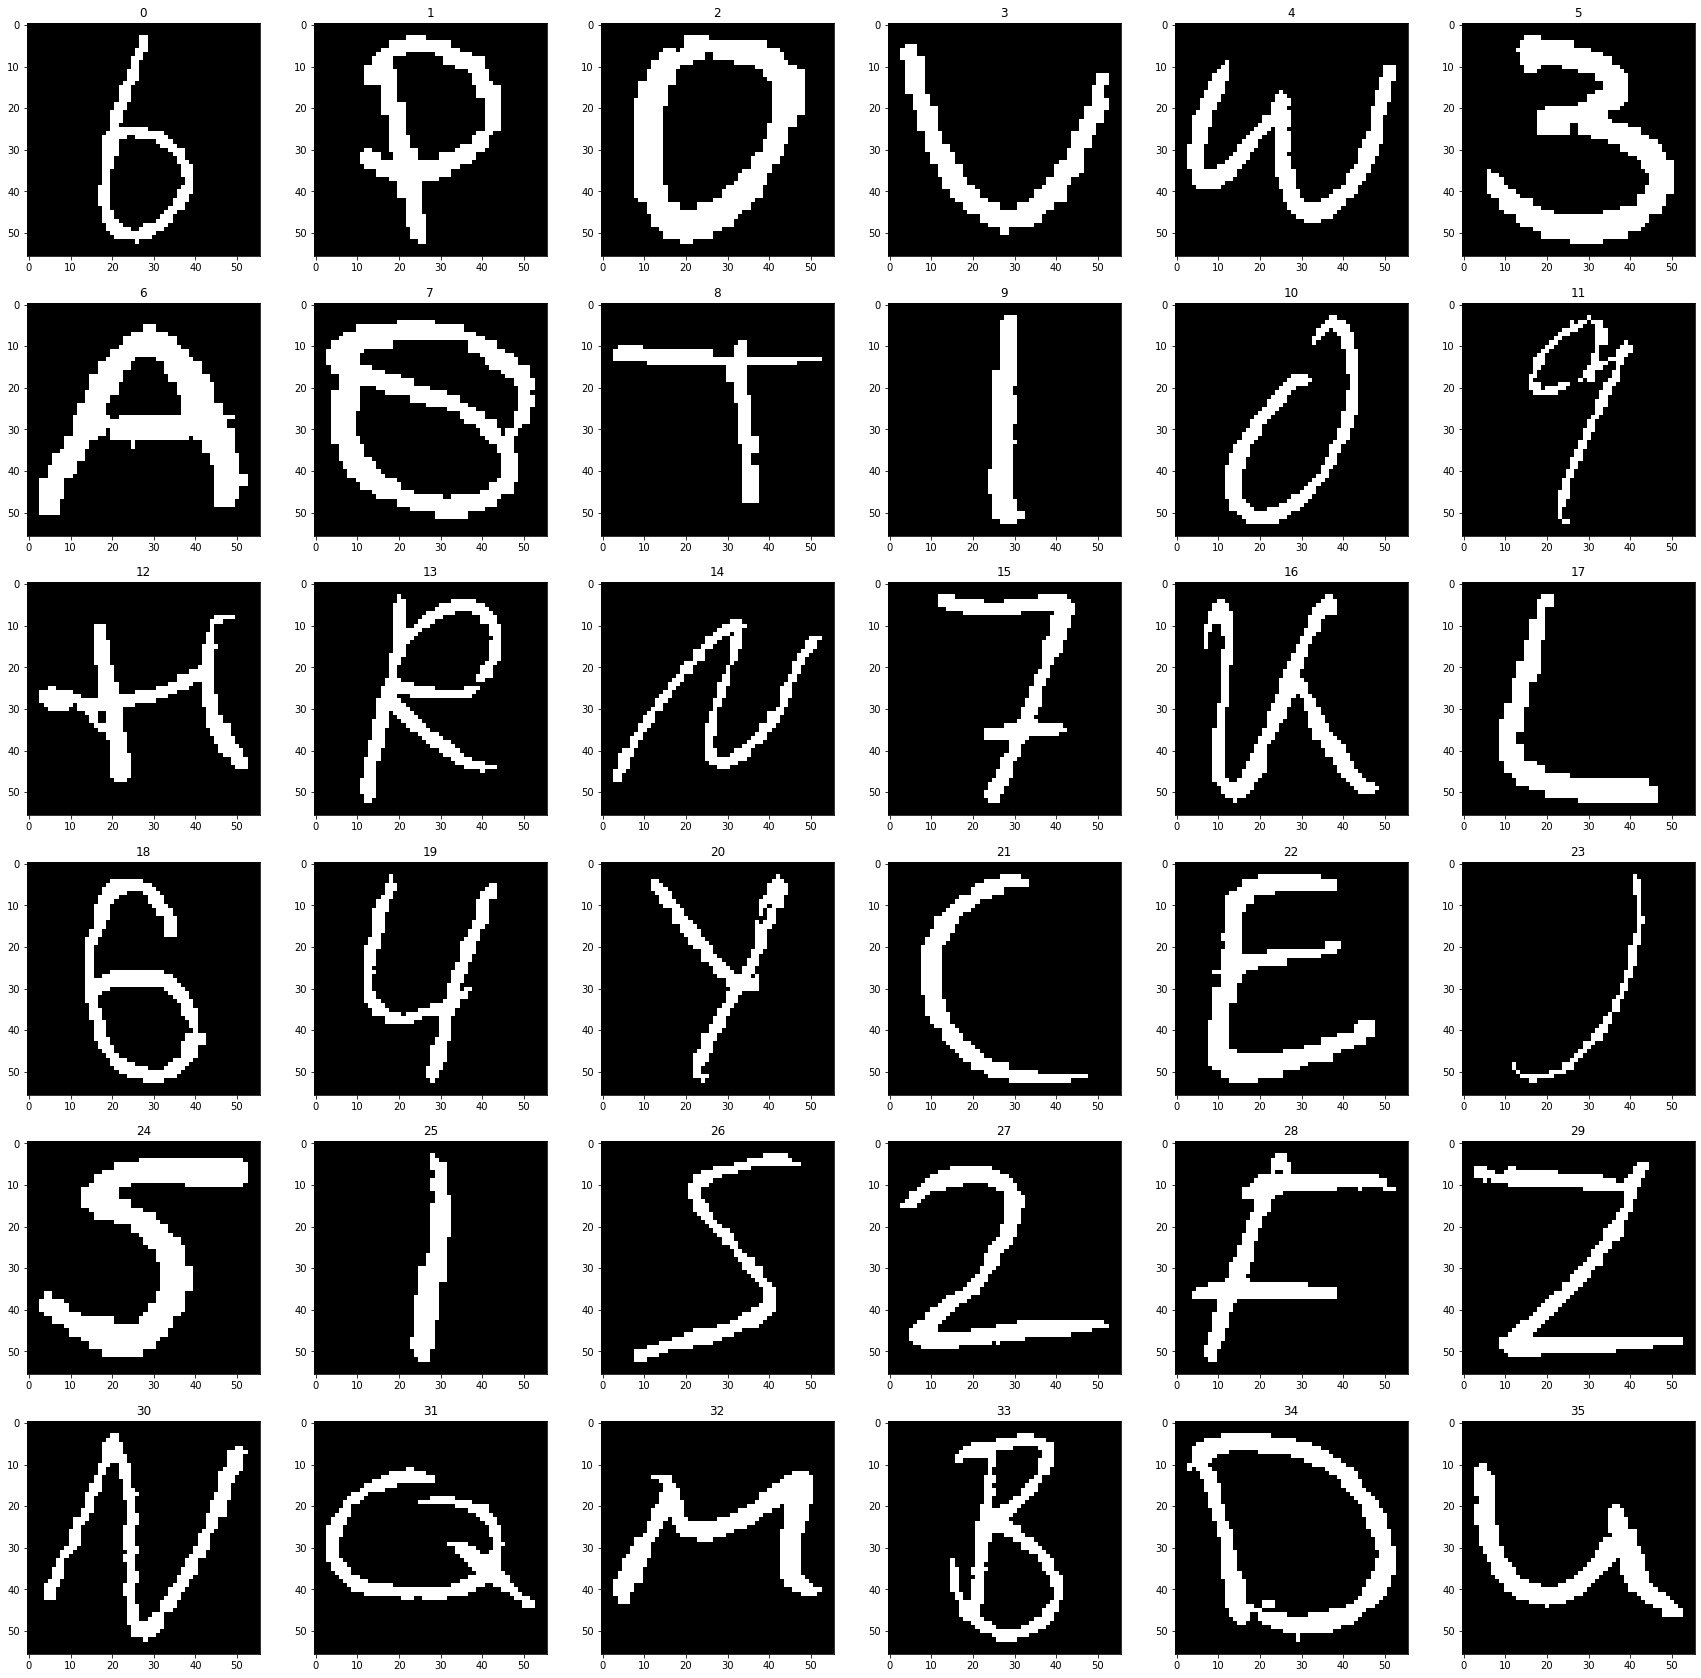

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30), nrows=6, ncols=6)

for row in range(6):
  for col in range(6):
    current = row * 6 + col
    class14 = np.where(y_train[:,0] == current)[0]
    ax[row][col].imshow(np.reshape(X_train[class14[0], :], (56, 56)), cmap='gray')
    ax[row][col].set_title(current)

plt.show()